In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [47]:
import itertools, sys

import catboost as cb
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

wids_path = ".."
sys.path.append(wids_path)
import global_vars as gv
# from global_vars import all_feature_columns, response_column
from utils import visualize as viz

pd.set_option("display.max_columns", 500)
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [3]:
model_type_dict = {
    "catboost": "catboost",
    "xgboost": "sklearn"
}

feature_dict = {
     "xgb_tune": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 9},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": True,
        "replace_original_feature_col_dict": {"energy_star_rating": "backfilled_energy_star_rating", "facility_type": "facility_type_parsed"},
        "drop_data": {}
    }
}

# tuning
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# max_depth, min_child_weight and gamma.
# subsample and colsample_bytree.
seed = 0
eta_list = [0.1, 0.2, 0.3]
max_depth_list = [3,6,9]
min_child_weight_list = [1,5,10]
gamma_list = [0,2,6]
subsample_list = [0.5,1]
colsample_bytree_list = [0.5,1]

<IPython.core.display.Javascript object>

In [57]:
def combine_rmse_results(
    config_name_list, eta_list = [0.1, 0.2, 0.3], max_depth_list = [3,6,9], min_child_weight_list = [1,5,10],
    gamma_list = [0,2,6], subsample_list = [0.5,1], colsample_bytree_list = [0.5,1]
):
    rmse_df = pd.DataFrame()
    for config_name in config_name_list:
        for eta, max_depth, min_child_weight, gamma, subsample, colsample_bytree in itertools.product(eta_list, max_depth_list, min_child_weight_list, gamma_list, subsample_list, colsample_bytree_list):
            updated_config_name = f"{config_name}_eta{eta}_max_depth{max_depth}_min_child_weight{min_child_weight}_gamma{gamma}_subsample{subsample}_colsample_bytree{colsample_bytree}"
            try:
                _df = pd.read_csv(
                    f"{wids_path}/validation_result/hannah/{updated_config_name}.csv"
                ).assign(
                    config=config_name, eta=eta, max_depth=max_depth, min_child_weight=min_child_weight, 
                    gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, updated_config_name = updated_config_name)
                rmse_df = pd.concat([rmse_df, _df], axis=0)
            except:
                print(f"{updated_config_name}.csv not found")
        rmse_df = rmse_df.reset_index(drop=True)
    return rmse_df

<IPython.core.display.Javascript object>

In [63]:
rmse_df = combine_rmse_results(["xgb_tune"])
rmse_df.shape

(2268, 12)

<IPython.core.display.Javascript object>

In [59]:
rmse_df.head()

,left_out_year,train_rmse,test_rmse,method,config,eta,max_depth,min_child_weight,gamma,subsample,colsample_bytree,updated_config_name
0,1.0,43.620963,62.934325,loyo,xgb_tune,0.1,3,1,0,0.5,0.5,xgb_tune_eta0.1_max_depth3_min_child_weight1_g...
1,2.0,44.064376,47.988117,loyo,xgb_tune,0.1,3,1,0,0.5,0.5,xgb_tune_eta0.1_max_depth3_min_child_weight1_g...
2,3.0,42.826056,53.317330,loyo,xgb_tune,0.1,3,1,0,0.5,0.5,xgb_tune_eta0.1_max_depth3_min_child_weight1_g...
3,4.0,44.214731,45.473861,loyo,xgb_tune,0.1,3,1,0,0.5,0.5,xgb_tune_eta0.1_max_depth3_min_child_weight1_g...
4,5.0,45.505224,40.511982,loyo,xgb_tune,0.1,3,1,0,0.5,0.5,xgb_tune_eta0.1_max_depth3_min_child_weight1_g...


<IPython.core.display.Javascript object>

In [60]:
def get_loy_summary(row_df):
    row_df = row_df.query("left_out_year != 0")
    return pd.DataFrame([row_df["train_rmse"].mean(), row_df["test_rmse"].mean()], index = ["train_rmse", "test_rmse"]).transpose()

<IPython.core.display.Javascript object>

In [64]:
avg_loy_rmse_df = rmse_df.groupby("updated_config_name").apply(get_loy_summary).reset_index()

<IPython.core.display.Javascript object>

In [65]:
min_test_rmse = avg_loy_rmse_df["test_rmse"].min()
min_test_rmse

44.6095355108938

<IPython.core.display.Javascript object>

In [66]:
avg_loy_rmse_df.query(f"test_rmse == {min_test_rmse}")

,updated_config_name,level_1,train_rmse,test_rmse
95,xgb_tune_eta0.1_max_depth9_min_child_weight1_g...,0,31.263607,44.609536


<IPython.core.display.Javascript object>

In [44]:
avg_loy_rmse_df.query(f"test_rmse == {min_test_rmse}")['config'].iloc[0]

'xgb_tune_eta0.1_max_depth9_min_child_weight1_gamma6_subsample1_colsample_bytree1'

<IPython.core.display.Javascript object>

In [83]:
set_tuning_param_dict = {
    "eta": 0.1,
    "max_depth": 9,
    "min_child_weight":1,
    "gamma":6,
    "subsample":1,
    "colsample_bytree":1
}

<IPython.core.display.Javascript object>

In [90]:
def get_one_tuning_param(param_dict, hue_col):
    query_string = ""
    for col, value in param_dict.items():
        if col != hue_col:
            query_string = f"{query_string} and {col} == {value}"
    return query_string

def plot_train_and_test_rmse(rmse_df, hue_col , param_dict):
    query_string = get_one_tuning_param(param_dict, hue_col)

    fig, axes = plt.subplots(figsize=(8, 8), nrows=2)
    sns.boxplot(
        data=rmse_df.query(f"method == 'loyo' {query_string}").sort_values("config"),
        x="config",
        y="train_rmse",
        hue=hue_col,
        ax=axes[0],
    )
    viz.add_median_labels(axes[0])
    sns.scatterplot(
        data=rmse_df.query(f"method == 'whole train' {query_string}").sort_values(
            "config"
        ),
        x="config",
        y="train_rmse",
        ax=axes[0],
        color="white",
        edgecolor="k",
        label="whole train",
        hue=hue_col,
    )
    _ = axes[0].set_xticklabels([])
    axes[0].legend(bbox_to_anchor=(1, 1))

    sns.boxplot(
        data=rmse_df.sort_values("config"),
        x="config",
        y="test_rmse",
        hue=hue_col,
        ax=axes[1],
    )
    _ = axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
    axes[1].legend(bbox_to_anchor=(1, 1))
    viz.add_median_labels(axes[1])
    fig.subplots_adjust(hspace=0)
    fig.suptitle(f"{hue_col}")

<IPython.core.display.Javascript object>

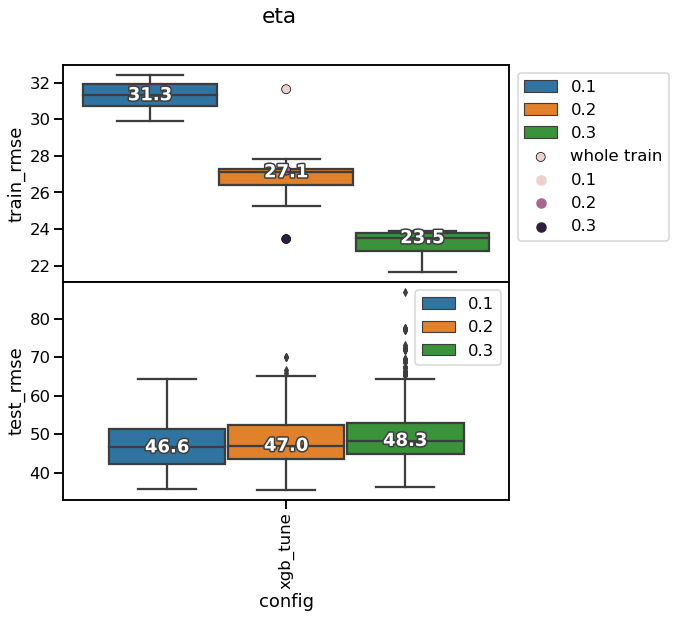

<IPython.core.display.Javascript object>

In [91]:
hue_col = "eta"
plot_train_and_test_rmse(rmse_df, hue_col , set_tuning_param_dict)

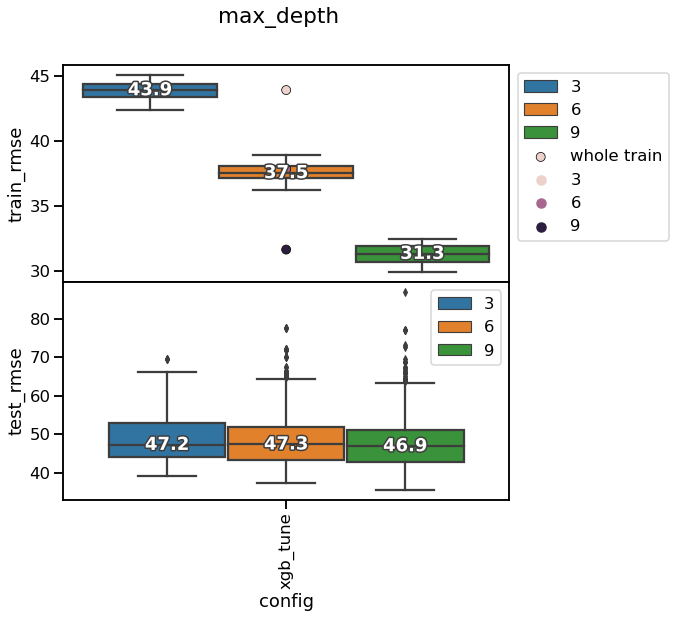

<IPython.core.display.Javascript object>

In [92]:
hue_col = "max_depth"
plot_train_and_test_rmse(rmse_df, hue_col , set_tuning_param_dict)

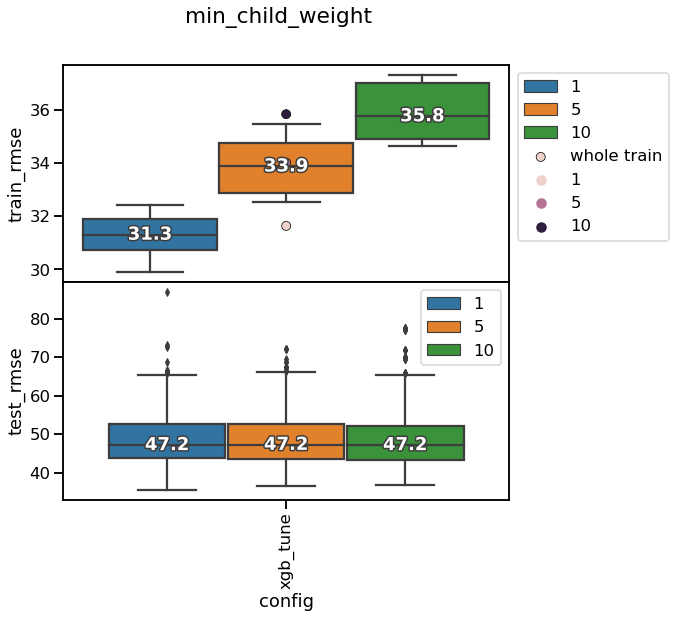

<IPython.core.display.Javascript object>

In [93]:
hue_col = "min_child_weight"
plot_train_and_test_rmse(rmse_df, hue_col , set_tuning_param_dict)

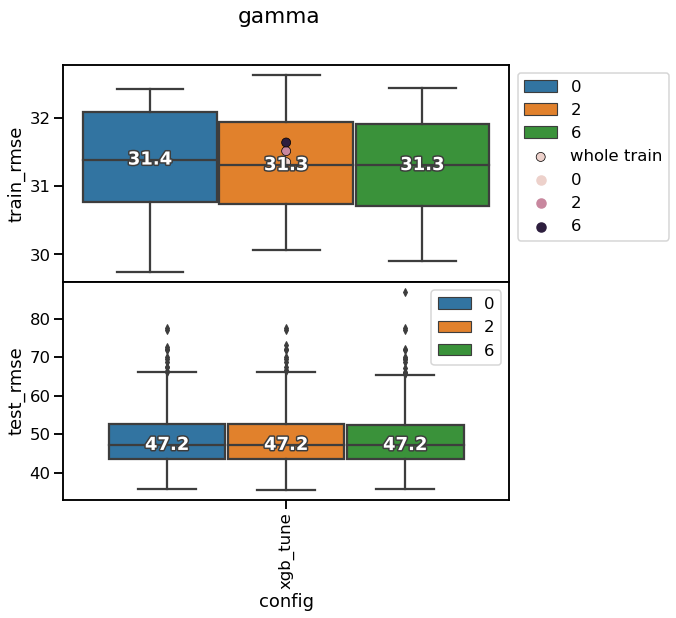

<IPython.core.display.Javascript object>

In [94]:
hue_col = "gamma"
plot_train_and_test_rmse(rmse_df, hue_col , set_tuning_param_dict)

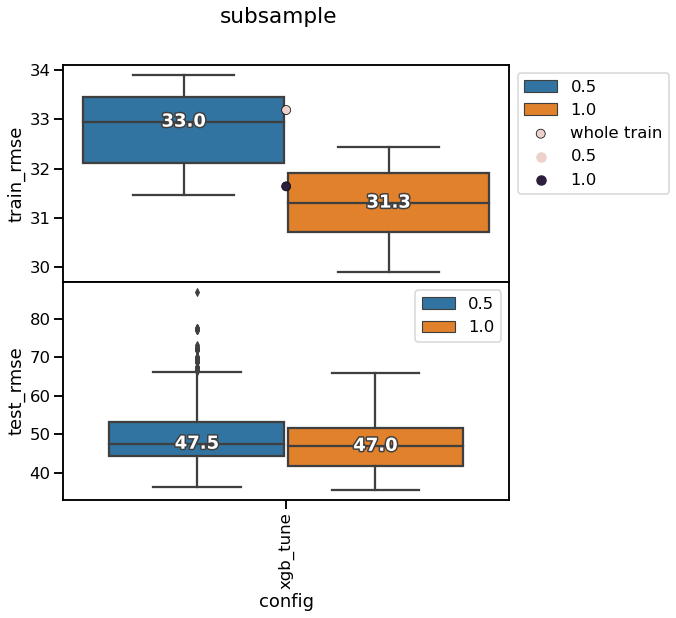

<IPython.core.display.Javascript object>

In [95]:
hue_col = "subsample"
plot_train_and_test_rmse(rmse_df, hue_col , set_tuning_param_dict)

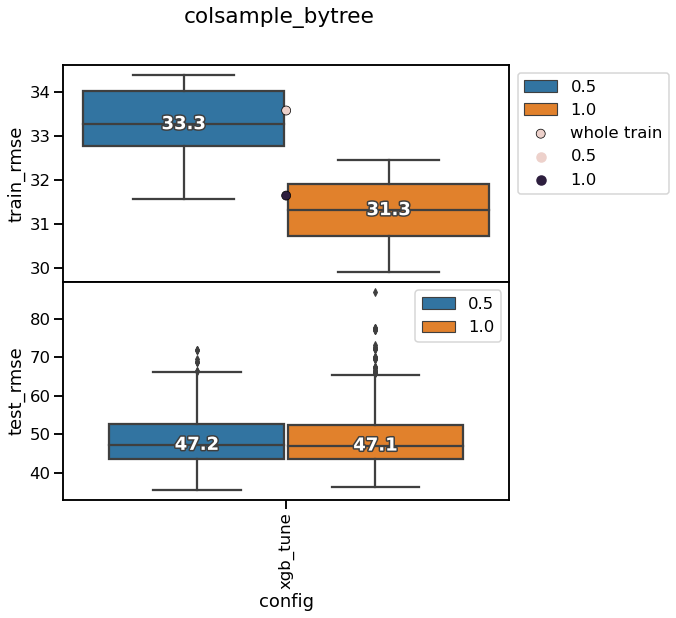

<IPython.core.display.Javascript object>

In [96]:
hue_col = "colsample_bytree"
plot_train_and_test_rmse(rmse_df, hue_col , set_tuning_param_dict)

In [88]:
set_tuning_param_dict.keys()

dict_keys(['eta', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree'])

<IPython.core.display.Javascript object>